# Summer HCHO CRACMM1 vs. CRACMM2

In [1]:
%matplotlib inline

In [2]:
import copy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

from cartopy_cmaqfile import cmaqfile

In [3]:
workdir = './'
data_dir = f'{workdir}/data'

## ocean mask file

In [4]:
ocnf = f'{data_dir}/oceanmask/12US1_surf.ncf'
ocn = xr.open_dataset(ocnf)
# 1 over land; NaN elsewhere; set threshold of 0.5 (i.e., mask if ocean > 0.5 grid cell area)
ocn_mask = xr.where(ocn['OPEN']>0.5, np.full(ocn['OPEN'].shape, np.nan), np.ones(ocn['OPEN'].shape)).squeeze().values
ocn.close()

## cmaq data

In [5]:
cases = ['CRACMM1','CRACMM2']
indir = f'{data_dir}/cmaq/seasonal_averages_annual'
# seasonal average (11am-3pm local time)
aconc_11to3 = {case: xr.open_dataset(f'./{indir}/combine_aconc_hcho_seasonal_mean_2019_11am_to_3pm_LST_{case}.nc') for case in cases}

## CMAQ grid projection info

In [6]:
gridcro_fn = f'{data_dir}/gridcro/GRIDCRO2D_20190101.nc4'
gridcro = xr.open_dataset(gridcro_fn)
gridcro = cmaqfile(gridcro)
Xcorners, Ycorners = gridcro.getXYcorners()
cmaqproj = gridcro.getCMAQproj()

## plot helper functions and settings

In [7]:
def txt_annot(Z, fmt='.1f'):
    txt = f'{Z.mean():{fmt}} ({Z.min():{fmt}}, {Z.max():{fmt}})'
    plt.annotate(txt, xy=(0, -.08), xycoords='axes fraction')

In [8]:
def axis_fix(ax):
    ax.coastlines(lw=.25)
    ax.add_feature(cfeature.STATES, lw=.25)
    ax.add_feature(cfeature.BORDERS, lw=.25)
    ax.set_facecolor('grey')

In [9]:
plt.rcParams.update({'font.size': 10})

## plot summer average 11am-3pm

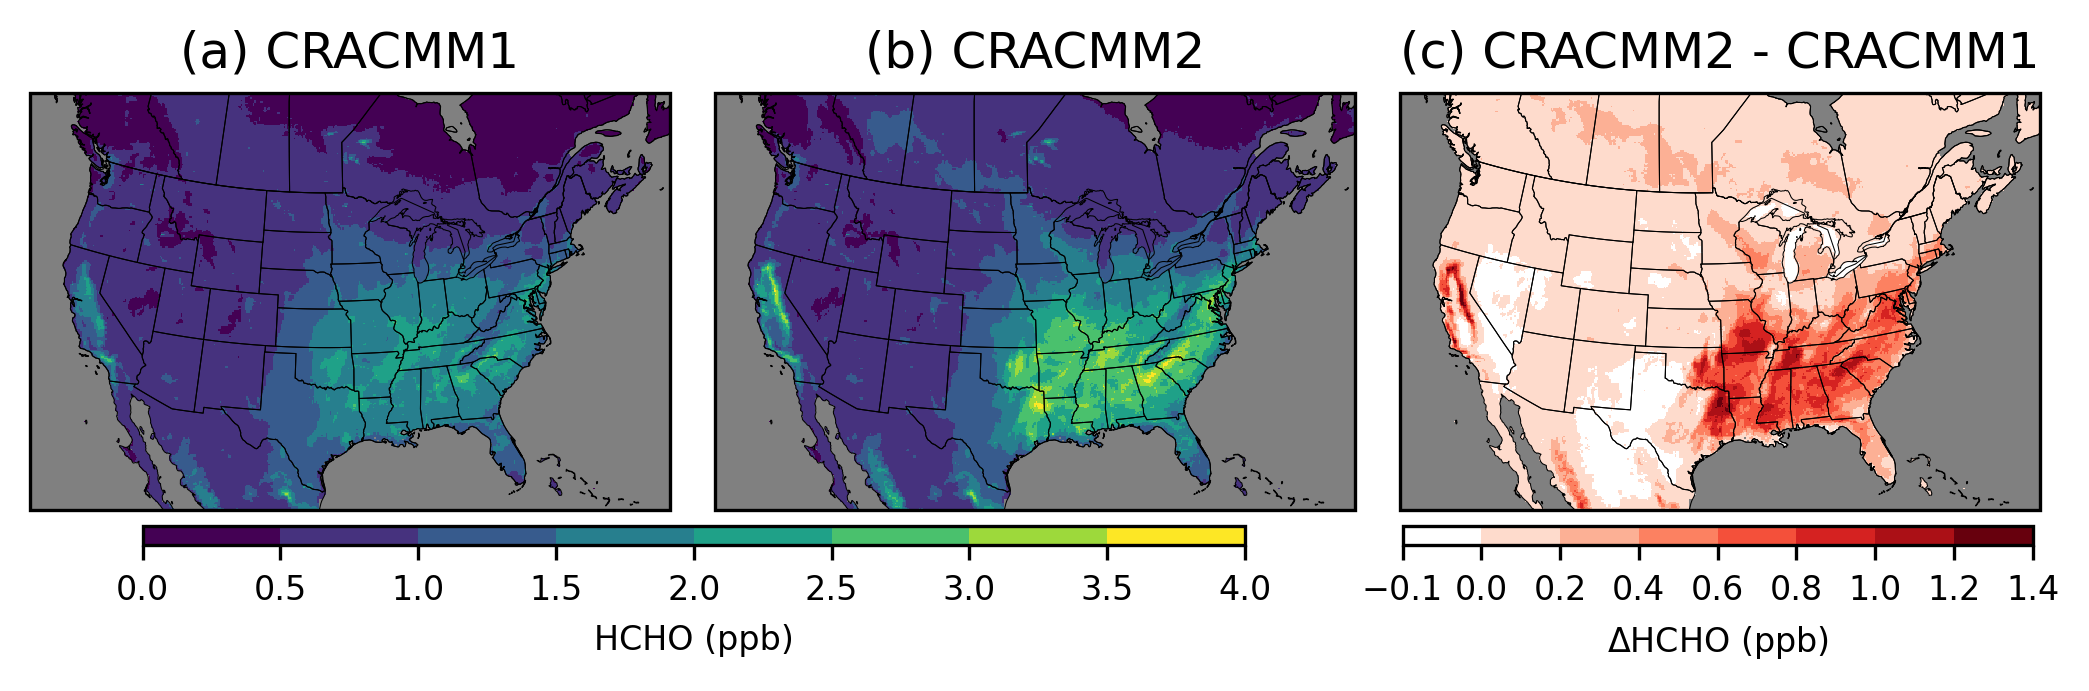

In [10]:
# discrete colorbar
bounds = np.arange(0., 4.01, .5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')
bounds_delta = [-.1, 0., .2, .4, .6, .8, 1., 1.2, 1.4]
norm_delta = mcolors.BoundaryNorm(boundaries=bounds_delta, ncolors=256, extend='neither')

fig = plt.figure(figsize=(7, 2.5), dpi=300)

season = 'JJA'
# cracmm1
ax1 = fig.add_subplot(131, projection=cmaqproj)
Z1 = aconc_11to3['CRACMM1']['HCHO'].sel(season=season).load()*ocn_mask
p1 = ax1.pcolormesh(
    Xcorners,
    Ycorners,
    Z1,
    cmap='viridis',
    norm=norm
)
# txt_annot(Z1)
axis_fix(ax1)
ax1.set_title('(a) CRACMM1')
# cracmm2
ax2 = fig.add_subplot(132, projection=cmaqproj)
Z2 = aconc_11to3['CRACMM2']['HCHO'].sel(season=season).load()*ocn_mask
p2 = ax2.pcolormesh(
    Xcorners,
    Ycorners,
    Z2,
    cmap='viridis',
    norm=norm
)
# txt_annot(Z2)
axis_fix(ax2)
ax2.set_title('(b) CRACMM2')
# cracmm2 - cracmm1
cmap = copy.copy(plt.cm.Reds)
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1.0, 1.0, 1.0, 1) # RGBA for white
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
ax3 = fig.add_subplot(133, projection=cmaqproj)
Z3 = Z2 - Z1
p3 = ax3.pcolormesh(
    Xcorners,
    Ycorners,
    Z3,
    cmap=cmap,
    norm=norm_delta
)
# txt_annot(Z3, fmt='.2f')
axis_fix(ax3)
ax3.set_title('(c) CRACMM2 - CRACMM1')

plt.tight_layout()

# colorbar
cax = fig.add_axes([.075, .175, 0.525, .025])
cbar_props = dict(orientation='horizontal')
cbar = plt.colorbar(p1, cax=cax, **cbar_props)
cbar.set_label('HCHO (ppb)', size=8)
cbar.ax.tick_params(labelsize=8)

cax_delta = fig.add_axes([.675, .175, .3, .025])
cbar_props_delta = dict(orientation='horizontal')
cbar_delta = plt.colorbar(p3, cax=cax_delta, **cbar_props_delta)
cbar_delta.set_label('$\Delta$HCHO (ppb)', size=8)
cbar_delta.ax.tick_params(labelsize=8)

fig.savefig('figures/fig02.tiff')